In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats
import seaborn as sns
sns.set_style("white",rc={"lines.linewidth":3})
sns.set_context("paper",font_scale=2.5)

In [2]:
from hide_code import HideCodeConfig as c
c.set('nested_params_depth', 7)

In [5]:
%load_ext autoreload
%autoreload 2
import hmc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In this notebook we will explore how to use [Hamiltonian Monte Carlo](https://arxiv.org/pdf/1206.1901.pdf) for sampling from posterior parameters of a [Multivariate Gaussian Distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution).

We start by generating samples from a bivariate Normal Distribution using a fixed mean and covariance, then we sample from posterior of distribution of each parameter given the other parameter is known. Finally we combine the two to sample from posterior distribution of joint parameter. Although we can apply HMC on both parameters, here we alternate between sampling from one parameter given the other (simulating Gibbs sampling).

# Generating Data

We generate a set of data by sampling from a Multivariate Normal Distribution. Probability Density of a Multivariate Normal Distribution is defined as:

\begin{align}
 \frac{1}{\sqrt{2 \pi \det(\Sigma)}} \exp{\left(-(\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu))\right)}
\end{align}

where:

$\mu: R^{N \times 1}$ vector, indicating the mean value.

$\Sigma: N^{N \times N}$ matrix, indicating the covariance matrix.

Here we generate samples from such a distribution with $N=2$.

In [4]:

sample_size = 10000
cov = np.array([[1.,-0.65],[-0.65,2]])
cov_inv = np.linalg.inv(cov)
mu_ = np.array([1,-3])
samples = []
mu = np.random.normal(0,1,size=2)
for i in range(sample_size):
    X = np.random.multivariate_normal(mu_,cov,size=1)
    samples.append(X)
samples = np.concatenate(samples)

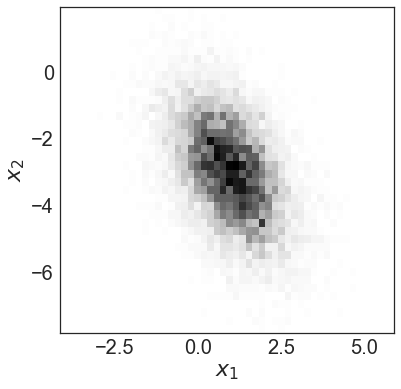

In [57]:
plt.figure(figsize=(6,6))
_ = plt.hist2d(samples[:,0],samples[:,1],bins=40,)
plt.axis("equal")
plt.xlabel("$x_1$")
_ =plt.ylabel("$x_2$")

# Inference

As we said earlier, we will resort to MCMA using Hamiltonian Monte Carlo. To give a bit of context for this method following quote from [the reference](https://arxiv.org/pdf/1206.1901.pdf) maybe useful:

> Hamiltonian dynamics has a physical interpretation that can provide useful intuitions. In
two dimensions, we can visualize the dynamics as that of a frictionless puck that slides over a surface of varying height. The state of this system consists of the position of the puck, given by a 2D vector $q$, and the momentum of the puck (its mass times its velocity), given by a 2D vector $p$. The potential energy, $U(q)$, of the puck is proportional to the height of the surface at its current position, and its kinetic energy, $K(p)$, is equal to $|p|2/(2m)$, where m is the mass of the puck. On a level part of the surface, the puck moves at a constant velocity, equal to $p/m$. If it encounters a rising slope, the puck’s momentum allows it to continue, with its kinetic energy decreasing and its potential energy increasing, until the kinetic energy (and hence p) is zero, at which point it will slide back down (with kinetic energy increasing and potential energy decreasing).

>In non-physical MCMC applications of Hamiltonian dynamics, the position will correspond
to the variables of interest. The potential energy will be minus the log of the probability
density for these variables. Momentum variables, one for each position variable, will
be introduced artificially.

Following the paper we learn that there are two quantities that we need for sampling using this method, 1) negative log likelihood $L$ and 2) derivative of negative of log likelihood with respect to parameter of interest, here $\mu$ and $\Sigma$, denoted by $\frac{\partial L}{\partial \mu}$ and $\frac{\partial L}{\partial \Sigma}$ respectively.

## Mean

In this section we derive the equations for inference of the mean, assuming covariance matrix is known. Based on earlier explanation we can derive the two quantities of interest using following formulas:

\begin{align}
  L &= \sum_i^N  \frac{-1}{2}\log\det(\Sigma) -(\frac{1}{2}(x_i-\mu)^T\Sigma^{-1}(x_i-\mu))\\
  \frac{\partial L}{\partial \mu} &= \sum_i^N  - \Sigma^{-1}(x_i-\mu)
\end{align}

For details of this derivation refer to [Matrix cook book](http://www2.imm.dtu.dk/pubdb/views/edoc_download.php/3274/pdf/imm3274.pdf). 

In [126]:
def logEnergy_mu(X,mu, cov):
    cov = np.reshape(cov, (X.shape[1],X.shape[1]))
    cov_inv = np.linalg.inv(cov)
    sum_ = 0   #0.5*(mu).T.dot(mu) uncomment this to add a normal prior.
    _, logdet = np.linalg.slogdet(cov)
    sum_ += X.shape[0]*logdet + ((X.T-mu).T.dot(cov_inv)*(X.T-mu).T).sum()
    return sum_


def grad_logEnergy_mu(X,mu, cov):
    cov = np.reshape(cov, (X.shape[1],X.shape[1]))
    sum_ = 0#-mu
    cov_inv = np.linalg.inv(cov)
    sum_ += -np.dot(cov_inv,X.T-mu).sum(axis=1, keepdims = True)
    return sum_


def p_sampler_mu():
    return np.random.normal(0,1, size= (X.shape[1],1))

In [127]:
U_mu = lambda mu: logEnergy_mu(samples, mu, cov)

In [128]:
U_der_mu = lambda mu: grad_logEnergy_mu(samples, mu, cov)

In [129]:
current_q = np.array([[-1.0],[-3.0]])
eps = 0.001
sample_gen = 2000
hist_val = []
hist_prob = []
hist_accept = []
for i in range(sample_gen):
    current_q, prob, accept = hmc.hmc(U_mu, U_der_mu, eps, L = 30, current_q = current_q, p_sampler=p_sampler_mu )
    hist_val.append(current_q)
    hist_prob.append(prob[0])
    hist_accept.append(accept)
    if i % 500 == 0:
        print(i)
        print(prob[0], accept)
        print(current_q)
hist_prob = np.concatenate(hist_prob)
hist_prob[hist_prob>1] = 1
hist_accept = np.array(hist_accept)
hist_val = np.concatenate(hist_val,axis=1).T

/Users/BehzadTab/Documents/Projects/Dengue/dengue_code/hmc.py:23: RuntimeWarning: overflow encountered in exp
  prob = np.exp(current_U - proposed_U + current_K - proposed_K)


0
[inf] 1
[[ 2.54140411]
 [-2.62903531]]
500
[1.01496591] 1
[[ 0.98047505]
 [-3.0073267 ]]
1000
[0.68234184] 1
[[ 0.98903253]
 [-3.00067582]]
1500
[0.75594102] 1
[[ 0.9797929 ]
 [-3.01712291]]


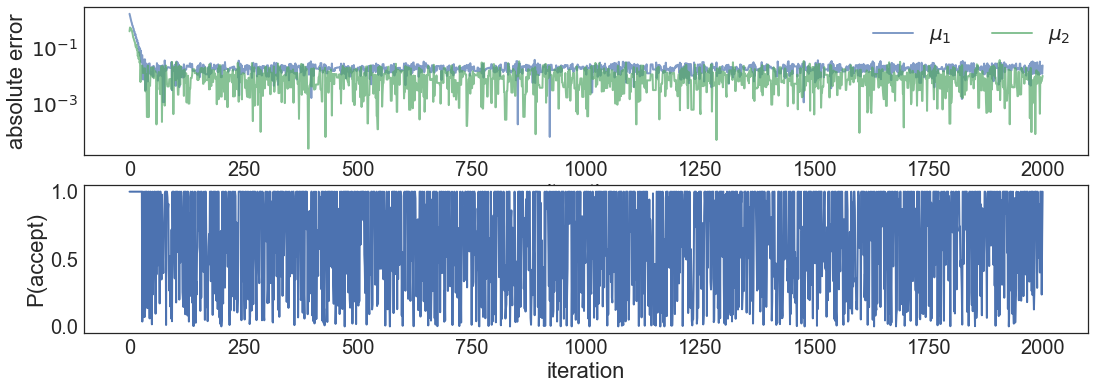

In [130]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(6*3,6))
gs = gridspec.GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0])
ax1.plot(np.abs(hist_val[:,0]-mu_[0].flatten()),alpha=0.7,label="$\mu_1$",linewidth=2)
ax1.plot(np.abs(hist_val[:,1]-mu_[1].flatten()),alpha=0.7,label="$\mu_2$",linewidth=2)
ax1.set_ylabel("absolute error")
ax1.set_xlabel("iteration")
ax1.set_yscale("log")
ax1.legend(loc=1,ncol=2)

ax2 = fig.add_subplot(gs[1],sharex=ax1)
ax2.plot(hist_prob,linewidth=2)
ax2.set_ylabel("P(accept)")
ax2.set_xlabel("iteration")

#plt.show()

## Covariance

In this section we derive the necessary equations for inference of the covariance matrix, assuming the vector mean is known. Based on earlier explanation we can derive the two quantities of interest using following formulas:
\begin{align}
  L &= \frac{-1}{2}\log\det(\Sigma) -(\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu))\\
  \frac{\partial L}{\partial \Sigma} &= \frac{-1}{2}( \Sigma^{-1} - \Sigma^{-1}(x-\mathbf{\mu})(x-\mathbf{\mu})^T\Sigma^{-1})
\end{align}

For details of this derivation refer to [Matrix cook book](http://www2.imm.dtu.dk/pubdb/views/edoc_download.php/3274/pdf/imm3274.pdf).

In [131]:
def logEnergy_cov(X,mu,cov):
    cov = np.reshape(cov, (X.shape[1],X.shape[1]))
    sum_ = 0
    _, logdet = np.linalg.slogdet(cov)
    cov_inv = np.linalg.inv(cov)
    sum_ += X.shape[0]*logdet + ((X.T-mu).T.dot(cov_inv)*(X.T-mu).T).sum()
    return sum_
def grad_logEnergy_cov(X,mu,cov):
    cov = np.reshape(cov, (X.shape[1],X.shape[1]))
    sum_ = 0
    cov_inv = np.linalg.inv(cov)
    sum_ = X.shape[0]*cov_inv-cov_inv.dot(np.einsum('ki,kj->ij', X-mu.T, X-mu.T)).dot(cov_inv)
    return np.reshape(sum_,(sum_.size,1)) 


In [132]:
U_cov = lambda cov: logEnergy_cov(samples, mu_[:,np.newaxis], cov)
U_der_cov = lambda cov: grad_logEnergy_cov(samples, mu_[:,np.newaxis], cov)

In [133]:
def p_sampler_cov():
    scale = np.diag(np.ones(samples.shape[1]))
    mat = stats.invwishart.rvs(5,scale,1)
    return np.reshape(mat,(mat.size,1)) 

In [134]:
current_q = np.array([[0.1,.0],[0.0,0.1]]).reshape((4,1))
eps = 0.001
sample_gen = 2000
hist_val = []
hist_prob = []
hist_accept = []
for i in range(sample_gen):
    current_q, prob, accept = hmc.hmc(U_cov, U_der_cov
                                      , eps, L = 30, current_q = current_q,p_sampler= p_sampler_cov )
    hist_val.append(current_q)
    hist_prob.append(prob[0])
    hist_accept.append(accept)
    if i % 500 == 0:
        print(i)
        print(prob[0], accept)
        print(current_q)
        print(np.linalg.eigvals(np.reshape(current_q,(samples.shape[1],samples.shape[1]))))
hist_prob = np.concatenate(hist_prob)
hist_prob[hist_prob>1] = 1
hist_accept = np.array(hist_accept)
hist_val = np.concatenate(hist_val,axis=1).T

/Users/BehzadTab/Documents/Projects/Dengue/dengue_code/hmc.py:23: RuntimeWarning: overflow encountered in exp
  prob = np.exp(current_U - proposed_U + current_K - proposed_K)


0
[inf] 1
[[13.32693171]
 [-9.79204045]
 [-9.79204045]
 [28.47246409]]
[ 8.52105322 33.27834257]
500
[1.09374877] 1
[[ 1.00402945]
 [-0.64625668]
 [-0.64625668]
 [ 2.0030968 ]]
[0.68675129 2.32037497]
1000
[1.04111324] 1
[[ 1.00823391]
 [-0.6528853 ]
 [-0.6528853 ]
 [ 2.01580853]]
[0.68736319 2.33667925]
1500
[0.95656293] 1
[[ 0.99652141]
 [-0.64556239]
 [-0.64556239]
 [ 2.00612195]]
[0.68182543 2.32081793]


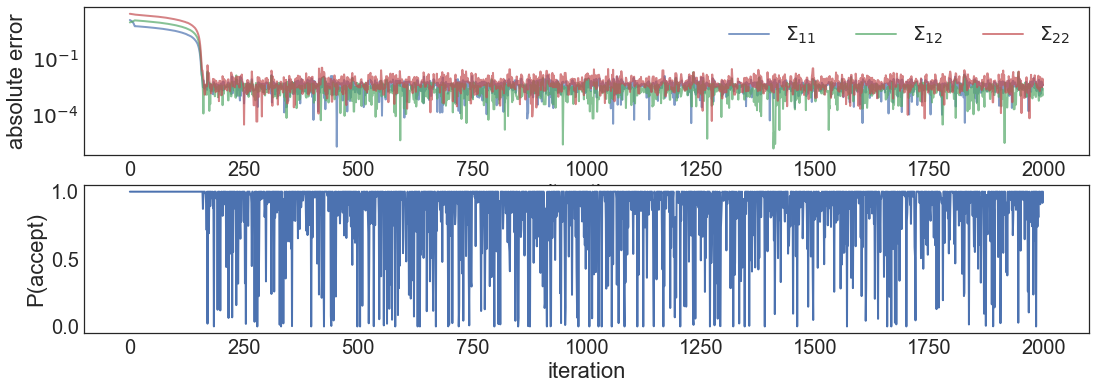

In [135]:
fig = plt.figure(figsize=(6*3,6))
gs = gridspec.GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0])
ax1.plot(np.abs(hist_val[:,0]-cov[0,0].flatten()),alpha=0.7,label="$\Sigma_{11}$",linewidth=2)
ax1.plot(np.abs(hist_val[:,1]-cov[0,1].flatten()),alpha=0.7,label="$\Sigma_{12}$",linewidth=2)
ax1.plot(np.abs(hist_val[:,3]-cov[1,1].flatten()),alpha=0.7,label="$\Sigma_{22}$",linewidth=2)

ax1.set_ylabel("absolute error")
ax1.set_xlabel("iteration")
ax1.set_yscale("log")
ax1.legend(loc=1,ncol=3)

ax2 = fig.add_subplot(gs[1],sharex=ax1)
ax2.plot(hist_prob,linewidth=2)
ax2.set_ylabel("P(accept)")
ax2.set_xlabel("iteration")

## Putting everything together
### Gibbs sampling style

In this section we use inference in previous sections to infere both parameters $\mu$ and $\Sigma$ simultaneously. In our first approach we alternate between parameters assuming th eother is fixed.


In [137]:
current_mu = np.array([[-1.0],[3.0]])
current_cov = np.array([[0.1,.0],[0.0,1.0]]).reshape((4,1))
eps = 0.001
sample_gen = 2000
hist_val_mu = []
hist_prob_mu = []
hist_accept_mu = []
hist_val_cov = []
hist_prob_cov = []
hist_accept_cov = []

for i in range(sample_gen):
    U_mu = lambda mu: logEnergy_mu(samples, mu, current_cov)
    U_der_mu = lambda mu: grad_logEnergy_mu(samples, mu, current_cov)
    U_cov = lambda cov: logEnergy_cov(samples, current_mu, cov)
    U_der_cov = lambda cov: grad_logEnergy_cov(samples, current_mu, cov)
    
    current_mu, prob_mu, accept_mu = hmc.hmc(U_mu, U_der_mu, eps, L = 30, current_q = current_mu,p_sampler= p_sampler_mu )
    hist_val_mu.append(current_mu)
    hist_prob_mu.append(prob_mu[0])
    hist_accept_mu.append(accept_mu)
    current_cov, prob_cov, accept_cov = hmc.hmc(U_cov, U_der_cov, eps, L = 30, current_q = current_cov,p_sampler= p_sampler_cov )
    hist_val_cov.append(current_cov)
    hist_prob_cov.append(prob_cov[0])
    hist_accept_cov.append(accept_cov)
    if i % 500 == 0:
        print(i)
        print("mu:",prob_mu[0], accept_mu,current_mu)
        print("cov:",prob_cov[0], accept_cov,current_cov)
hist_prob_mu = np.concatenate(hist_prob_mu)
hist_prob_mu[hist_prob_mu>1] = 1
hist_accept_mu = np.array(hist_accept_mu)
hist_val_mu = np.concatenate(hist_val_mu,axis=1).T

hist_prob_cov = np.concatenate(hist_prob_cov)
hist_prob_cov[hist_prob_cov>1] = 1
hist_accept_cov = np.array(hist_accept_cov)
hist_val_cov = np.concatenate(hist_val_cov,axis=1).T

/Users/BehzadTab/Documents/Projects/Dengue/dengue_code/hmc.py:23: RuntimeWarning: overflow encountered in exp
  prob = np.exp(current_U - proposed_U + current_K - proposed_K)


0
mu: [inf] 1 [[ 2.95340484]
 [-8.95958539]]
cov: [inf] 1 [[ 71.91943329]
 [-16.2577794 ]
 [-16.2577794 ]
 [ 25.45512864]]
500
mu: [2.55635149] 1 [[ 1.03775916]
 [-3.0435093 ]]
cov: [1.95861292e+13] 1 [[ 33.22740466]
 [-23.08944426]
 [-23.08944426]
 [ 17.62223532]]
1000
mu: [0.93232473] 1 [[ 0.97859534]
 [-2.99754338]]
cov: [1.15852968] 1 [[ 1.00393028]
 [-0.64862346]
 [-0.64862346]
 [ 2.00329913]]
1500
mu: [1.44962654] 1 [[ 0.97786999]
 [-3.0112067 ]]
cov: [1.01427662] 1 [[ 1.00184343]
 [-0.64561358]
 [-0.64561358]
 [ 2.0047486 ]]


As we can see below, inference still works however it takes longer (close to 1000 samples unlike 10 to 100 samples in previous cases) for MCMC method to pass the burnning phase and generate samples from the posterior.

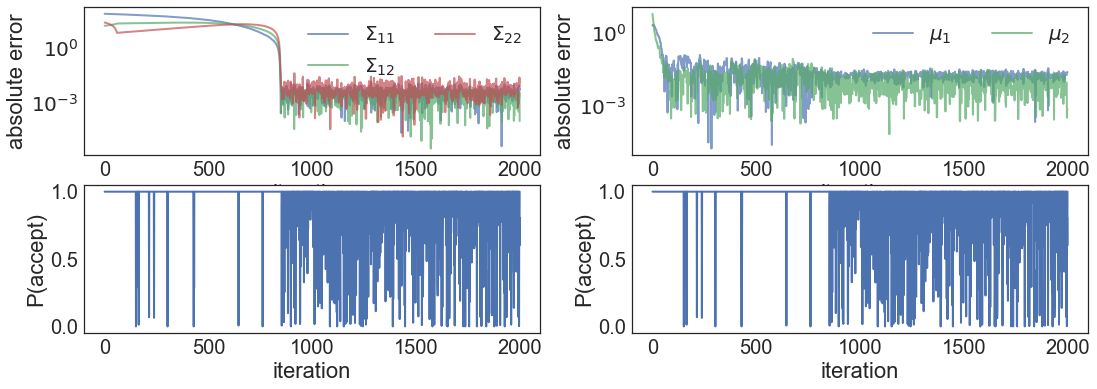

In [145]:
fig = plt.figure(figsize=(6*3,6))
gs = gridspec.GridSpec(2, 2)
ax1 = fig.add_subplot(gs[0,0])
ax1.plot(np.abs(hist_val_cov[:,0]-cov[0,0].flatten()),alpha=0.7,label="$\Sigma_{11}$",linewidth=2)
ax1.plot(np.abs(hist_val_cov[:,1]-cov[0,1].flatten()),alpha=0.7,label="$\Sigma_{12}$",linewidth=2)
ax1.plot(np.abs(hist_val_cov[:,3]-cov[1,1].flatten()),alpha=0.7,label="$\Sigma_{22}$",linewidth=2)

ax1.set_ylabel("absolute error")
ax1.set_xlabel("iteration")
ax1.set_yscale("log")
ax1.legend(loc=1,ncol=2)

ax2 = fig.add_subplot(gs[1,0],sharex=ax1)
ax2.plot(hist_prob_cov,linewidth=2)
ax2.set_ylabel("P(accept)")
ax2.set_xlabel("iteration")

ax3 = fig.add_subplot(gs[0,1])
ax3.plot(np.abs(hist_val_mu[:,0]-mu_[0].flatten()),alpha=0.7,label="$\mu_{1}$",linewidth=2)
ax3.plot(np.abs(hist_val_mu[:,1]-mu_[1].flatten()),alpha=0.7,label="$\mu_{2}$",linewidth=2)

ax3.set_ylabel("absolute error")
ax3.set_xlabel("iteration")
ax3.set_yscale("log")
ax3.legend(loc=1,ncol=3)

ax4 = fig.add_subplot(gs[1,1],sharex=ax1)
ax4.plot(hist_prob_cov,linewidth=2)
ax4.set_ylabel("P(accept)")
ax4.set_xlabel("iteration")